# Regression with Amazon SageMaker XGBoost algorithm
_**Single machine training for regression with Amazon SageMaker XGBoost algorithm**_

---

---
## Contents
1. [Introduction](#Introduction)
2. [Setup](#Setup)
  1. [Fetching the dataset](#Fetching-the-dataset)
  2. [Data Ingestion](#Data-ingestion)
3. [Training the XGBoost model](#Training-the-XGBoost-model)
  1. [Plotting evaluation metrics](#Plotting-evaluation-metrics)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
5. [Validate the model for use](#Validate-the-model-for-use)

---
## Introduction

This notebook demonstrates the use of Amazon SageMaker’s implementation of the XGBoost algorithm to train and host a regression model. We use the [Abalone data](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html) originally from the [UCI data repository](https://archive.ics.uci.edu/ml/datasets/abalone). More details about the original dataset can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names).  In the libsvm converted [version](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html), the nominal feature (Male/Female/Infant) has been converted into a real valued feature. Age of abalone is to be predicted from eight physical measurements.  

---
## Setup


This notebook was created and tested on an ml.m4.4xlarge notebook instance.

Let's start by specifying:
1. The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
1. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
%%time

import os
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
region = boto3.Session().region_name
accountID = boto3.client('sts').get_caller_identity()['Account']

# Bucket to use for training data and model
#bucket='datascience-project-'+accountID
#Replace REPLACE-BUCKET-NAME with the BucketName from the product provisioned using Service Catalog.
bucket='REPLACE-BUCKET-NAME'
#bucket='sc-324793933254-pp-ube432dc-datascientists3bucket-1x7i6jje1u86c'

print('Datascience project bucket is : ', bucket)

Couldn't call 'get_role' to get Role ARN from role name SC-324793933254-pp-ube432dc-SageMakerExecutionRole-1AEJ7EBTZ6V9G to get Role path.


Datascience project bucket is :  sc-324793933254-pp-ube432dc-datascientists3bucket-1x7i6jje1u86c
CPU times: user 812 ms, sys: 104 ms, total: 917 ms
Wall time: 11 s


In [2]:
prefix = 'sagemaker/DEMO-xgboost-regression'
# customize to your bucket where you have stored the data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

### Fetching the dataset

Following methods split the data into train/test/validation datasets and upload files to S3.

In [3]:
%%time

import io
import boto3
import random

def data_split(FILE_DATA, FILE_TRAIN, FILE_VALIDATION, FILE_TEST, PERCENT_TRAIN, PERCENT_VALIDATION, PERCENT_TEST):
    data = [l for l in open(FILE_DATA, 'r')]
    train_file = open(FILE_TRAIN, 'w')
    valid_file = open(FILE_VALIDATION, 'w')
    tests_file = open(FILE_TEST, 'w')

    num_of_data = len(data)
    num_train = int((PERCENT_TRAIN/100.0)*num_of_data)
    num_valid = int((PERCENT_VALIDATION/100.0)*num_of_data)
    num_tests = int((PERCENT_TEST/100.0)*num_of_data)

    data_fractions = [num_train, num_valid, num_tests]
    split_data = [[],[],[]]

    rand_data_ind = 0

    for split_ind, fraction in enumerate(data_fractions):
        for i in range(fraction):
            rand_data_ind = random.randint(0, len(data)-1)
            split_data[split_ind].append(data[rand_data_ind])
            data.pop(rand_data_ind)

    for l in split_data[0]:
        train_file.write(l)

    for l in split_data[1]:
        valid_file.write(l)

    for l in split_data[2]:
        tests_file.write(l)

    train_file.close()
    valid_file.close()
    tests_file.close()

def write_to_s3(fobj, bucket, key):
    return boto3.Session(region_name=region).resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel
    url = 's3://{}/{}/{}'.format(bucket, key, filename)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11 µs


### Data ingestion

Next, we read the dataset from the existing repository into memory, for preprocessing prior to training. This processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

In [4]:
%%time
import urllib.request

# Load the dataset
FILE_DATA = 'abalone'
urllib.request.urlretrieve("https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/abalone", FILE_DATA)

#split the downloaded data into train/test/validation files
FILE_TRAIN = 'abalone.train'
FILE_VALIDATION = 'abalone.validation'
FILE_TEST = 'abalone.test'
PERCENT_TRAIN = 70
PERCENT_VALIDATION = 15
PERCENT_TEST = 15
data_split(FILE_DATA, FILE_TRAIN, FILE_VALIDATION, FILE_TEST, PERCENT_TRAIN, PERCENT_VALIDATION, PERCENT_TEST)

#upload the files to the S3 bucket
upload_to_s3(bucket, 'train', FILE_TRAIN)
upload_to_s3(bucket, 'validation', FILE_VALIDATION)
upload_to_s3(bucket, 'test', FILE_TEST)

Writing to s3://sc-324793933254-pp-ube432dc-datascientists3bucket-1x7i6jje1u86c/sagemaker/DEMO-xgboost-regression/train/abalone.train
Writing to s3://sc-324793933254-pp-ube432dc-datascientists3bucket-1x7i6jje1u86c/sagemaker/DEMO-xgboost-regression/validation/abalone.validation
Writing to s3://sc-324793933254-pp-ube432dc-datascientists3bucket-1x7i6jje1u86c/sagemaker/DEMO-xgboost-regression/test/abalone.test
CPU times: user 201 ms, sys: 18 ms, total: 219 ms
Wall time: 2.96 s


## Training the XGBoost model

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 5 and 6 minutes.

In [5]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region, 'xgboost')
print(container)

	get_image_uri(region, 'xgboost', '0.90-1').


825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:1


In [9]:
%%time
import boto3
from time import gmtime, strftime

job_name = 'DEMO-xgboost-regression-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

#Ensure that the training and validation data folders generated above are reflected in the "InputDataConfig" parameter below.

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": bucket_path + "/" + prefix + "/single-xgboost"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m4.4xlarge",
        "VolumeSizeInGB": 5
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "silent":"0",
        "objective":"reg:linear",
        "num_round":"50"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 3600
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/" + prefix + '/train',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/" + prefix + '/validation',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        }
    ]
}


client = boto3.client('sagemaker', region_name=region)
client.create_training_job(**create_training_params)

import time

status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)
while status !='Completed' and status!='Failed':
    time.sleep(60)
    status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)

Training job DEMO-xgboost-regression-2020-03-08-03-29-00
InProgress
InProgress
InProgress
Completed
CPU times: user 53.8 ms, sys: 9.54 ms, total: 63.4 ms
Wall time: 3min


Note that the "validation" channel has been initialized too. The SageMaker XGBoost algorithm actually calculates RMSE and writes it to the CloudWatch logs on the data passed to the "validation" channel.

### Plotting evaluation metrics
Evaluation metrics for the completed training job are available in CloudWatch. We can pull the area under curve metric for the validation data set and plot it to see the performance of the model over time.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


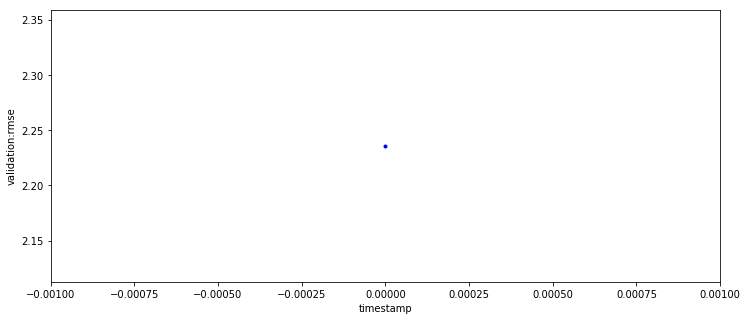

In [12]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

metric_name = 'validation:rmse'

metrics_dataframe = TrainingJobAnalytics(training_job_name=job_name, metric_names=[metric_name]).dataframe()
plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b.', legend=False)
plt.set_ylabel(metric_name);

## Set up hosting for the model
In order to set up hosting, we have to import the model from training to hosting. 

### Import model into hosting

Register the model with hosting. This allows the flexibility of importing models trained elsewhere.

In [16]:
%%time
import boto3
from time import gmtime, strftime

model_name=job_name + '-model'
print(model_name)

info = client.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

DEMO-xgboost-regression-2020-03-08-03-29-00-model
https://s3-us-east-2.amazonaws.com/sc-324793933254-pp-ube432dc-datascientists3bucket-1x7i6jje1u86c/sagemaker/DEMO-xgboost-regression/single-xgboost/DEMO-xgboost-regression-2020-03-08-03-29-00/output/model.tar.gz
arn:aws:sagemaker:us-east-2:324793933254:model/demo-xgboost-regression-2020-03-08-03-29-00-model
CPU times: user 13.1 ms, sys: 3.75 ms, total: 16.9 ms
Wall time: 886 ms


### Create endpoint configuration

SageMaker supports configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way. In addition, the endpoint configuration describes the instance type required for model deployment.

In [17]:
from time import gmtime, strftime

endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-XGBoostEndpointConfig-2020-03-08-03-38-09
Endpoint Config Arn: arn:aws:sagemaker:us-east-2:324793933254:endpoint-config/demo-xgboostendpointconfig-2020-03-08-03-38-09


### Create endpoint
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [23]:
%%time
import time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
endpoint_name = 'DEMO-XGBoostEndpoint-2020-03-08-03-39-11'
print(endpoint_name)
#create_endpoint_response = client.create_endpoint(
 #   EndpointName=endpoint_name,
  #  EndpointConfigName=endpoint_config_name)
#print(create_endpoint_response['EndpointArn'])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

DEMO-XGBoostEndpoint-2020-03-08-03-39-11
Status: InService
Arn: arn:aws:sagemaker:us-east-2:324793933254:endpoint/demo-xgboostendpoint-2020-03-08-03-39-11
Status: InService
CPU times: user 12.2 ms, sys: 0 ns, total: 12.2 ms
Wall time: 106 ms


## Validate the model for use
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [24]:
runtime_client = boto3.client('runtime.sagemaker', region_name=region)

Start with a single prediction.

In [25]:
!head -1 abalone.test > abalone.single.test

In [26]:
%%time
import json
from itertools import islice
import math
import struct

file_name = 'abalone.single.test' #customize to your test file
with open(file_name, 'r') as f:
    payload = f.read().strip()
response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/x-libsvm', 
                                   Body=payload)
result = response['Body'].read()
result = result.decode("utf-8")
result = result.split(',')
result = [math.ceil(float(i)) for i in result]
label = payload.strip(' ').split()[0]
print ('Label: ',label,'\nPrediction: ', result[0])

Label:  10 
Prediction:  9
CPU times: user 12.8 ms, sys: 525 µs, total: 13.4 ms
Wall time: 223 ms


OK, a single prediction works. Let's do a whole batch to see how good is the predictions accuracy.

In [27]:
import sys
import math
def do_predict(data, endpoint_name, content_type):
    payload = '\n'.join(data)
    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType=content_type, 
                                   Body=payload)
    result = response['Body'].read()
    result = result.decode("utf-8")
    result = result.split(',')
    preds = [float((num)) for num in result]
    preds = [math.ceil(num) for num in preds]
    return preds

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)], endpoint_name, content_type)
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items], endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

The following helps us calculate the Median Absolute Percent Error (MdAPE) on the batch dataset. 

In [28]:
%%time
import json
import numpy as np

with open(FILE_TEST, 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 100, endpoint_name, 'text/x-libsvm')

print('\n Median Absolute Percent Error (MdAPE) = ', np.median(np.abs(np.array(labels) - np.array(preds)) / np.array(labels)))

.......
 Median Absolute Percent Error (MdAPE) =  0.125
CPU times: user 19.8 ms, sys: 1.31 ms, total: 21.2 ms
Wall time: 128 ms


### Delete Endpoint
Once you are done using the endpoint, you can use the following to delete it. 

In [ ]:
##client.delete_endpoint(EndpointName=endpoint_name)

## Copy the trained model to the IT tools account

When ready to hand over the trained model and test data to IT, execute the cells below.
It will kickoff the MLOps pipeline

In [29]:
#First download the model
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

https://s3-us-east-2.amazonaws.com/sc-324793933254-pp-ube432dc-datascientists3bucket-1x7i6jje1u86c/sagemaker/DEMO-xgboost-regression/single-xgboost/DEMO-xgboost-regression-2020-03-08-03-29-00/output/model.tar.gz


In [30]:
bucket_and_key_list= model_data.split('/')
print(bucket_and_key_list)
source_bucket=bucket_and_key_list[3]
print(source_bucket)
key=""
for x in range(4, len(bucket_and_key_list)):
    key+=bucket_and_key_list[x]
    if(x != len(bucket_and_key_list) - 1):
        key+="/"
print(key)

['https:', '', 's3-us-east-2.amazonaws.com', 'sc-324793933254-pp-ube432dc-datascientists3bucket-1x7i6jje1u86c', 'sagemaker', 'DEMO-xgboost-regression', 'single-xgboost', 'DEMO-xgboost-regression-2020-03-08-03-29-00', 'output', 'model.tar.gz']
sc-324793933254-pp-ube432dc-datascientists3bucket-1x7i6jje1u86c
sagemaker/DEMO-xgboost-regression/single-xgboost/DEMO-xgboost-regression-2020-03-08-03-29-00/output/model.tar.gz


In [31]:
import boto3

s3 = boto3.client('s3')

trained_model_file = 'local-model.tar.gz'
s3.download_file(source_bucket, key, trained_model_file)
print("Model downloaded ", trained_model_file)

Model downloaded  local-model.tar.gz


In [32]:
tools_account_access_arn=!echo $tools_account_access_role_arn
tools_bucket=!echo $tools_bucket_name

print("tools_account_access_arn : ", tools_account_access_arn)
print("tools_bucket : ", tools_bucket)
#print(type(tools_bucket))

tools_account_access_arn :  ['arn:aws:iam::324793933254:role/AllowAccessToDataScienceAccountRole-324793933254']
tools_bucket :  ['mlops-bia-data-model-324793933254']


In [33]:
tools_model = 'models/model.tar.gz'
tools_test_data = 'data/abalone.test'
tools_validation_data = 'data/abalone.validation'

local_validation_data = 'abalone.validation'
local_test_data = 'abalone.test'

In [34]:
sts_connection = boto3.client('sts')
acct_b = sts_connection.assume_role(
    RoleArn=tools_account_access_arn[0],
    RoleSessionName="cross_acct_lambda"
)

ACCESS_KEY = acct_b['Credentials']['AccessKeyId']
SECRET_KEY = acct_b['Credentials']['SecretAccessKey']
SESSION_TOKEN = acct_b['Credentials']['SessionToken']

# create service client using the assumed role credentials, e.g. S3
tools_s3_client = boto3.client(
    's3',
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    aws_session_token=SESSION_TOKEN,
)

print("tools_s3_client ", tools_s3_client)

print("Copying trained model to IT account ...")
with open(trained_model_file, "rb") as f:
    tools_s3_client.upload_fileobj(f, tools_bucket[0], tools_model)
print("Copying trained model to IT account - Done")

print("Copying validation data to IT account ...")
with open(local_validation_data, "rb") as f:
    tools_s3_client.upload_fileobj(f, tools_bucket[0], tools_validation_data)
print("Copying validation data to IT account - Done")

print("Copying test data to IT account ...")
with open(local_test_data, "rb") as f:
    tools_s3_client.upload_fileobj(f, tools_bucket[0], tools_test_data)
print("Copying test data to IT account - Done")

ClientError: An error occurred (AccessDenied) when calling the AssumeRole operation: User: arn:aws:sts::324793933254:assumed-role/SC-324793933254-pp-ube432dc-SageMakerExecutionRole-1AEJ7EBTZ6V9G/SageMaker is not authorized to perform: sts:AssumeRole on resource: arn:aws:iam::324793933254:role/AllowAccessToDataScienceAccountRole-324793933254